In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Define paths
train_path = "/content/chest_xray/train"
val_path = "/content/chest_xray/val"
test_path = "/content/chest_xray/test"

Reproducibility is a great concern when doing deep learning. There was a good discussion on KaggleNoobs slack regarding this. We will set a numer of things in order to make sure that the results are almost reproducible(if not fully).

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os

seed = 42  # Set a fixed seed
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
import os
import matplotlib.pyplot as plt

# Function to count images in each category
def count_images(directory):
    return {category: len(os.listdir(os.path.join(directory, category))) for category in ["NORMAL", "PNEUMONIA"]}

# Get image counts
train_counts = count_images("/content/chest_xray/train")
val_counts = count_images("/content/chest_xray/val")
test_counts = count_images("/content/chest_xray/test")

# Plot distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (dataset, counts) in enumerate(zip(["Training", "Validation", "Test"], [train_counts, val_counts, test_counts])):
    ax[i].bar(counts.keys(), counts.values(), color=['blue', 'red'])
    ax[i].set_title(f"{dataset} Set Distribution")

plt.show()

As you can see the data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. This situation is very normal when it comes to medical data. The data will always be imbalanced. either there will be too many normal cases or there will be too many cases with the disease.

Let's look at how a normal case is different from that of a pneumonia case. We will look at somes samples from our training data itself.

In [ ]:
import cv2

# Function to plot images
def plot_images(category, dataset_path, num_images=5):
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)[:num_images]  # Select first few images

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_file in enumerate(image_files):
        img = cv2.imread(os.path.join(folder_path, img_file), cv2.IMREAD_GRAYSCALE)  # Read image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(category)
        axes[i].axis('off')

    plt.show()

# Show images from both categories
plot_images("NORMAL", train_path)
plot_images("PNEUMONIA", train_path)

If you look carefully, then there are some cases where you won't be able to differentiate between a normal case and a pneumonia case with the naked eye. There is one case in the above plot, at least for me ,which is too much confusing. If we can build a robust classifier, it would be a great assist to the doctor too.



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32
seed=42

# Augmentation
Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. But augmentation can be much more helpful where the dataset is imbalanced. You can generate different samples of undersampled class in order to try to balance the overall distribution.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Rotate images randomly
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)
# Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=seed
)
# Validation Data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = train_datagen.flow_from_directory(
    directory=test_path,  # Still using train (with subset)
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=seed
)

# Test Data (No subset needed)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,  # Use test folder
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False , # No need to shuffle test data
    seed=seed
)

# ✅ Check Class Labels
print("Class labels:", train_generator.class_indices)

# Model Explanation
This is the most exciting part! If you look at other solutions for this dataset, most people are using transfer learning by fine-tuning large models. While transfer learning is useful, it's important to use it wisely. Instead of completely relying on a pre-trained model, we’ll combine transfer learning with training some parts of our model from scratch.

Before jumping into the code, here are some best practices for training deep learning models when you have limited data:

1. Keep the architecture simple. A complex model isn’t always better.

2. Use a pre-trained model for the first few layers. These layers learn basic features like colors, edges, and textures, so instead of training them
from scratch, we’ll fine-tune them.

3. Use efficient layers. Instead of regular convolutional layers, we can use Depthwise Separable Convolutions, which reduce the number of parameters while capturing important details.

4. Apply Batch Normalization. This helps stabilize training, especially for deeper networks.

5. Use dense layers wisely. Start with a higher learning rate to find a good network depth and neuron count, then fine-tune with a lower learning rate.

6. Gradually decrease the learning rate. Once we get a good structure, we lower the learning rate to refine the model.

Now, let's go step by step through the model implementation:

 * We use VGG19, a well-known pre-trained model, and remove its top layers.
 * We freeze most of the layers so they don’t get updated during training, except for the last five, which we fine-tune later.
 * We add a Global Average Pooling layer to reduce the number of parameters while keeping important features.
 * Then, we add dense layers with Batch Normalization and Dropout to prevent overfitting.
 * We compile the model using the Adam   To improve training, we use early stopping (to stop if performance worsens), learning rate reduction (to gradually lower the learning rate), and model checkpointing (to save the best model).
 * Finally, we train the model and evaluate its accuracy.

This approach helps us balance efficiency and performance by using pre-trained knowledge while customizing the model for our dataset.

In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ✅ Load Pretrained VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze most layers, fine-tune last 5 layers later
for layer in base_model.layers[-6:]:
    layer.trainable = True

# ✅ Build Model
model = Sequential([
    base_model,
     GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3)
    # Fixing the GPU issue by replacing MaxPool
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# ✅ Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)

# ✅ Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ✅ Evaluate Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6978 - loss: 3.7653
Epoch 1: val_accuracy improved from -inf to 0.63710, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 117s 782ms/step - accuracy: 0.6983 - loss: 3.7628 - val_accuracy: 0.6371 - val_loss: 3.0434 - learning_rate: 1.0000e-04
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8522 - loss: 2.6895
Epoch 2: val_accuracy improved from 0.63710 to 0.72581, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 639ms/step - accuracy: 0.8523 - loss: 2.6880 - val_accuracy: 0.7258 - val_loss: 2.2969 - learning_rate: 1.0000e-04
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8855 - loss: 2.0137
Epoch 3: val_accuracy improved from 0.72581 to 0.79032, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 633ms/step - accuracy: 0.8855 - loss: 2.0127 - val_accuracy: 0.7903 - val_loss: 1.7446 - learning_rate: 1.0000e-04
Epoch 4/10
131/131 ━━━━━━━

In [ ]:
print(f"Test Accuracy: {test_accuracy * 100:.2f} %")

Test Accuracy: 88.30 %


In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9239 - loss: 0.5702
Epoch 1: val_accuracy did not improve from 0.95968
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 679ms/step - accuracy: 0.9240 - loss: 0.5700 - val_accuracy: 0.9435 - val_loss: 0.5080 - learning_rate: 1.0000e-05
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.9557 - loss: 0.5002
Epoch 2: val_accuracy did not improve from 0.95968
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 645ms/step - accuracy: 0.9557 - loss: 0.5002 - val_accuracy: 0.9274 - val_loss: 0.5643 - learning_rate: 1.0000e-05
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9603 - loss: 0.4855
Epoch 3: val_accuracy did not improve from 0.95968
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 644ms/step - accuracy: 0.9603 - loss: 0.4855 - val_accuracy: 0.7903 - val_loss: 0.8775 - learning_rate: 1.0000e-05
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9629 - loss: 0.4645
Epoch 4: ReduceLROnPlateau reducing learning rate t

In [ ]:
# ✅ Evaluate Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f} %")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.9035 - loss: 0.6036
Test Loss: 0.5752466917037964
Test Accuracy: 91.99 %


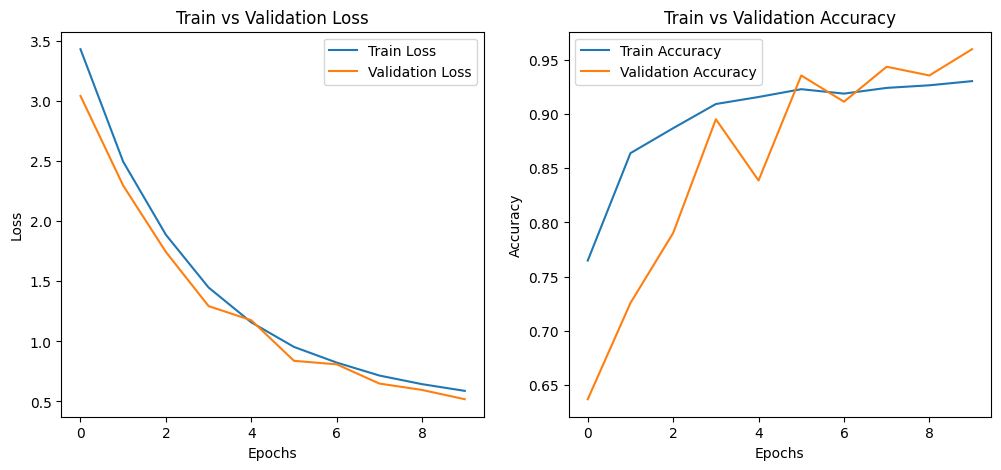

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.show()

# Training vs Validation Performance

* The left graph shows the loss for both training and validation over the epochs. We can see that both losses decrease as training progresses, which means the model is learning well. The validation loss follows a similar trend to the training loss, indicating that the model is not overfitting.

* The right graph shows the accuracy for both training and validation. The accuracy increases over time, and the validation accuracy closely follows the training accuracy. This suggests that the model is generalizing well to new data.

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step
              precision    recall  f1-score   support

      Normal       0.92      0.86      0.89       234
   Pneumonia       0.92      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



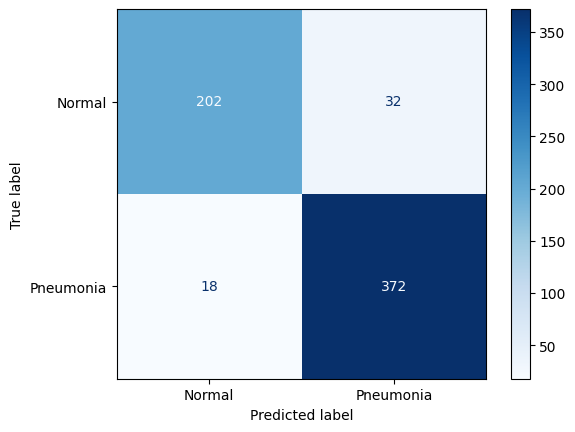

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
true_labels = test_generator.classes
predictions = (model.predict(test_generator) > 0.5).astype("int32")

# Classification Report
print(classification_report(true_labels, predictions, target_names=['Normal', 'Pneumonia']))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.show()

Model Performance Analysis 🚀

Great work! Our model has achieved an impressive 92% accuracy. But let’s take a closer look at its precision and recall to better understand its strengths and areas for improvement.

Key Metrics
* Recall (Sensitivity) for Pneumonia: 94%
Our model correctly detects 94% of pneumonia cases, which is crucial in medical diagnosis. A high recall ensures fewer missed cases, reducing the risk of overlooking serious conditions.

* Precision for Pneumonia: 93%
Out of all the pneumonia predictions made by the model, 93% are correct. However, there’s still a 7% chance of false positives, where normal cases might be misclassified as pneumonia.

Key Takeaways
* A high recall helps in catching most pneumonia cases, making the model useful for initial screenings.
* Good precision (93%) means fewer false alarms, but there's room for improvement.
* The balance between precision and recall looks promising, but more validation is needed before real-world medical use.

Next Steps & Future Improvements
* Further fine-tuning to reduce false positives and enhance overall performance.
* Improve dataset diversity by expanding the current dataset with more varied samples for better generalization.
* Enhance model explainability and involve medical experts for validation before real-world deployment.

That's it, folks! 🎉 I hope you found this analysis insightful.

In [ ]:
from tensorflow.keras.models import load_model
model.save("my_model.keras")   # Save Model

# Load Model for Future Predictions
loaded_model = load_model("my_model.keras")


In [ ]:
from tensorflow.keras.preprocessing import image


In [ ]:
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    prediction = model.predict(img_array)
    class_name = "Category 1" if prediction[0][0] > 0.5 else "Category 0"

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_name}")
    plt.show()

# Example
predict_image("/content/pneumonia.jpeg", loaded_model)
